In [1]:
# Package imports
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random
import time
import math
import pdb
import pickle
import pandas as pd
from sklearn import preprocessing
import seaborn as sns
import os
import time

#### Interesting Results with conf:
# batch_size = 50
# num_epochs = 100
# n_folds = 1
# lr = 0.01
# featx = 96
# def mlp(input_,input_dim,output_dim,name="mlp"):
#     with tf.variable_scope(name):
#         w = tf.get_variable('w',[input_dim,output_dim],tf.float32,tf.random_normal_initializer(mean = 0.0001,stddev=0.001))
#         #w = tf.get_variable('w',[input_dim,output_dim],tf.float32,tf.contrib.layers.xavier_initializer())
#         return tf.nn.tanh(tf.matmul(input_,w))
# node_sizes = {'input':featx,'l1':50,'l2':50,'output':2,'kernel_dim':5,'max_pool_redux_factor':16}

In [21]:
# Model Architecture Defs
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

#MLP
def build_model(X_,_dropout,node_sizes,net_type,phase):
    if net_type == 'mlpnet':
        model = mlpnet(X_,_dropout,node_sizes,phase)
    elif net_type == 'convnet':
        model = convnet(X_,_dropout,node_sizes)
    elif net_type == 'auxnet':
        model = auxnet(X_,node_sizes)
    else: 
        print('unknown net architecture type')
    return model

def mlpnet(X_,_dropout,node_sizes,phase):
    l1 = mlp(X_,node_sizes['input'],node_sizes['l1'],name='l1')
    #batch normalization
#     l1 = tf.contrib.layers.batch_norm(l1, center=True, scale=True, updates_collections=None, 
#                                       decay=0.9, is_training=phase,scope='bn1')
    l1 = tf.nn.dropout(l1,_dropout)
    l2 = mlp(l1,node_sizes['l1'],node_sizes['l2'],name='l2')
    #batch normalization
#     l2 = tf.contrib.layers.batch_norm(l2, center=True, scale=True, updates_collections=None, 
#                                       decay=0.9, is_training=phase,scope='bn2')    
    #l2 = tf.nn.dropout(l2,_dropout)
    
    l3 = mlp(l2,node_sizes['l2'],node_sizes['l3'],name='l3')
    l4 = mlp(l3,node_sizes['l3'],node_sizes['output'],name='l4')
#     l4 = tf.contrib.layers.batch_norm(l4, center=False, scale=True, updates_collections=None, 
#                                       decay=0.9, is_training=phase,scope='bn4')    
#     #l4 = tf.layers.normalization.batch_normalization (l4, name='bn4')
    return l4

def auxnet(X_,node_sizes):
    aux_softmax = mlp(X_,node_sizes['aux_in'],node_sizes['aux_out'],name='aux_l1')    
    #aux_softmax = mlp(aux_l1,node_sizes['aux_out'],node_sizes['aux_out'],name='aux_soft')    
    return aux_softmax


def mlp(input_,input_dim,output_dim,name="mlp"):
    with tf.variable_scope(name):
        #w = tf.get_variable('w',[input_dim,output_dim],tf.float32,tf.random_normal_initializer(mean = 0.001,stddev=0.02))
        w = tf.get_variable('w',[input_dim,output_dim],tf.float32,tf.contrib.layers.xavier_initializer())
    
    #return tf.nn.relu(tf.matmul(input_,w))
    return tf.nn.tanh(tf.matmul(input_,w))

#Convnet
def convnet(X_,_dropout,node_sizes):
    image_dim = int(np.sqrt(node_sizes['input']))
    final_image_vector_size = node_sizes['input']/node_sizes['max_pool_redux_factor']
    
    X_image = tf.reshape(X_, [-1,image_dim,image_dim,1])
    l1 = conv(X_image,node_sizes['kernel_dim'], 1, node_sizes['l1'], name='l1')  
    l1 = tf.nn.dropout(l1,_dropout)
    l2 = conv(l1,node_sizes['kernel_dim'], node_sizes['l1'], node_sizes['l2'], name='l2')
    l2 = tf.nn.dropout(l2,_dropout)
    
    #reshape to vector (reduced image size*number of filters)
    l2_flat = tf.reshape(l2, [-1, final_image_vector_size*node_sizes['l2']])    
    l3 = mlp(l2_flat,final_image_vector_size*node_sizes['l2'],node_sizes['output'],name='mlp')    
    #l3 = tf.nn.dropout(l3,_dropout) #Doesnt work well
    return l3
    
def conv(input_, kernel_dim, in_channels, output_dim,name="conv"):
    with tf.variable_scope(name):
        W = tf.get_variable('w',[kernel_dim, kernel_dim, in_channels, output_dim],
                            tf.float32,tf.random_normal_initializer(mean = 0.01,stddev=0.02))
        b = tf.get_variable('b',[output_dim],tf.float32,tf.constant_initializer(0.1))                        
        h_conv = tf.nn.relu(conv2d(input_, W) + b)
        h_pool = max_pool_2x2(h_conv)
        return h_pool
    
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        
# def weight_variable(shape):
#     initial = tf.truncated_normal(shape, stddev=0.1)
#     return tf.Variable(initial)

# def bias_variable(shape):
#     initial = tf.constant(0.1, shape=shape)
#     return tf.Variable(initial)

# Loss and accuracy
def contrastive_loss(y,d,score_mod,use_mod,use_auxnet):            
    if use_auxnet:
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y,logits=d)) 
        
    else: #This is purly contrastive
        if use_mod:
            loss1 = y *tf.square(d*score_mod)
            #tmp= tf.mul(y,tf.square(d))
            loss2 = (1-y) *tf.square(tf.maximum((1 - d*score_mod),0))
        else:
            loss1 = y *tf.square(d)
            #tmp= tf.mul(y,tf.square(d))
            loss2 = (1-y) *tf.square(tf.maximum((1 - d),0))
        
        loss = tf.reduce_mean(loss1 +loss2)/2         
    
    return loss

# Odd distance based indexing
# def compute_accuracy(prediction,labels):
#     return labels[prediction.ravel() < 0.5].mean()
#     #return tf.reduce_mean(labels[prediction.ravel() < 0.5])
    
def compute_accuracy(prediction,labels,use_aux_net):
    if use_aux_net:
        correct_prediction = tf.equal(tf.argmax(prediction,1), tf.argmax(labels,1))
    else:
        pred_labels = prediction.ravel() < 0.5
        correct_prediction = tf.equal(pred_labels,labels.ravel())
        
    acc = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))        
    return acc
    
def next_batch(s,e,inputs,labels,tr_delta_t,aux_var_dict,use_aux_net):
    input1 = inputs[s:e,0]
    input2 = inputs[s:e,1]        
    
    tr_batch_delta_t = np.reshape(tr_delta_t[s:e],(len(range(s,e)),1))
    
    aux_var_batch_dict = {}    
    if use_aux_net:
        y = np.reshape(labels[s:e],(len(range(s,e)),2)) #softmax output        
        for aux_var in aux_var_dict:
            aux_var_batch_dict[aux_var] = np.reshape(aux_var_dict[aux_var][s:e],(len(range(s,e)),1))
    else:
        y = np.reshape(labels[s:e],(len(range(s,e)),1))
    
        
    return input1,input2,y,tr_batch_delta_t,aux_var_batch_dict

def create_pairs(x, digit_indices):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    left_digits = []
    right_digits = []
    n = min([len(digit_indices[d]) for d in range(10)]) - 1
    for d in range(10):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i+1]
            pairs += [[x[z1], x[z2]]]            
            left_digits.append(d)
            right_digits.append(d)            
            inc = random.randrange(1, 10)
            dn = (d + inc) % 10
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
            left_digits.append(d)
            right_digits.append(dn)
    return np.array(pairs), np.array(labels), np.array(left_digits), np.array(right_digits)


def pickleIt(my_data,save_path):
    f = open(save_path, 'wb')
    pickle.dump(my_data, f,protocol=2)
    f.close()

In [91]:
# Load data

baseline_dir = '/projects/nbhagwat/Traj_prediction/ADNI/exp_setup/'
demo_cols = ['AGE','APOE4']
cohort = 'ALL_ADNI'
clinical_scale = 'MMSE'
exp_name = 'Exp_102_{}_traj_{}_tp_var_tp'.format(cohort,clinical_scale)
use_cs = True
use_ct = False
var_tp = False
shuffle_labels = False # What's your performance with random labels. 
scale_data = False
feat_sufix = ''

exp_setup_path = baseline_dir + 'KFolds/' + exp_name + '_sKF.pkl'

with open(exp_setup_path, 'rb') as f:
    exp_setup = pickle.load(f, encoding='latin') 


#Check if loading the correct experimental setup
if exp_name != exp_setup['exp_name']:
    print('Incorrect exp_name. Selected:{}, Retrieved:{}'.format(exp_name, exp_setup['exp_name']))

else:
    print('exp_name: {}'.format(exp_name))
    
    df = exp_setup['df']
    kf = exp_setup['sKF']
    
    feat_cols = []    
    
    if use_cs:
        print('using CS columns')
        if var_tp:
            cs_cols = ['MMSE_bl','MMSE_var_tp'] #+ demo_cols
        else:
            cs_cols = ['MMSE_bl'] + demo_cols
        feat_cols = feat_cols + cs_cols
        feat_sufix = feat_sufix + '_CS'
        print(len(feat_cols))
        
        
    if use_ct:   
        print('using CT columns')
        if var_tp:
            ct_cols_bl = list(df.columns[pd.Series(df.columns).str.contains('CT_bl')])
            ct_cols_tp_rate = list(df.columns[pd.Series(df.columns).str.contains('CT_var_tp')])
            ct_cols = ct_cols_bl + ct_cols_tp_rate
        else:
            ct_cols = list(df.columns[pd.Series(df.columns).str.contains('CT')])

        feat_cols = feat_cols + ct_cols
        feat_sufix = feat_sufix + '_CT'
        print(len(feat_cols))

    X_raw = np.array(df[feat_cols]) #Otherwise scaling and shifting will remain the same for next model. 
    y = np.array(df['traj']) 
    
    #Flip labels (sanity check to see of contrastive loss is dependent on the label values)
    #y = np.square(y-1)
    
    print('X,y shapes:{},{}'.format(X_raw.shape,y.shape))
    
    # Create list of all the fold-subsets (needed for parallelization)
    Sub_train_kf =[]
    Sub_test_kf = []
    X_train_kf = []
    X_test_kf = []
    y_train_kf = []
    y_test_kf = []    
    delta_t_train_kf = []
    delta_t_test_kf = []
    age_train_kf = []
    age_test_kf = []
    apoe_train_kf = []
    apoe_test_kf = []
    cs_bl_train_kf = []
    cs_bl_test_kf = []
    cs_tp_train_kf = []
    cs_tp_test_kf = []
        
    for train, test in kf:
        Sub_train_kf.append(df['PTID'].values[train]) 
        Sub_test_kf.append(df['PTID'].values[test])         
        delta_t_train_kf.append(df['tp'].values[train]/12.0)
        delta_t_test_kf.append(df['tp'].values[test]/12.0)  
        
        age_train_kf.append(df['AGE'].values[train]/100.0)
        age_test_kf.append(df['AGE'].values[test]/100.0)        
        apoe_train_kf.append(df['APOE4'].values[train]/2.0)
        apoe_test_kf.append(df['APOE4'].values[test]/2.0)        
        
        cs_bl_train_kf.append(df['MMSE_bl'].values[train]/30.0)
        cs_bl_test_kf.append(df['MMSE_bl'].values[test]/30.0)        
        cs_tp_train_kf.append(df['MMSE_var_tp'].values[train]/30.0)
        cs_tp_test_kf.append(df['MMSE_var_tp'].values[test]/30.0)        
        
        X_tr = X_raw[train]
        y_tr = y[train]
        X_te = X_raw[test]
        y_te = y[test]

        if scale_data:
            scaler = preprocessing.StandardScaler().fit(X_tr)
            X_tr = scaler.transform(X_tr)
            X_te = scaler.transform(X_te)
            
            
        X_train_kf.append(X_tr)
        y_train_kf.append(y_tr)

        # No need to resample test data
        X_test_kf.append(X_te)            
        y_test_kf.append(y_te)

exp_name: Exp_102_ALL_ADNI_traj_MMSE_tp_var_tp
using CS columns
3
X,y shapes:(1167, 3),(1167,)


In [23]:
delta_t_test_kf[0]

array([ 1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  0.5,  1. ,  1. ,  1. ,  1. ,
        1. ,  1. ,  1. ,  1. ,  1. ,  0.5,  0.5,  0.5,  1. ,  1. ,  1. ,
        1. ,  1. ,  1. ,  0.5,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,
        1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,
        1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,
        1. ,  1. ])

In [89]:
# Run models
batch_size = 100
num_epochs = 50
n_folds = 10
lr = 0.005
keep_p = 1
tp_offset = 78

use_mod = False
use_delta_t = False
use_aux_net = False

model_choice = 'Siamese_Layer2_aux'
save_perf = True

#Track performance for each fold
kf_train_acc = []
kf_valid_acc = []
kf_test_acc = []
df_perf_concat = pd.DataFrame()
#global_step = tf.Variable(0,trainable=False)
#starter_learning_rate = 0.0001
#learning_rate = tf.train.exponential_decay(starter_learning_rate,global_step,10,0.1,staircase=True)
net_arch_list = [{'input':79,'l1':5,'l2':5,'l3':50,'output':10,'aux_in':5,'aux_out':2}]

start_time = time.time()
for fid in [2,6]: #range(n_folds):  
    print('')
    print('Foldx:{}'.format(fid+1))
    df_perf = pd.DataFrame()
    hyp_tr_perf_list = []
    hyp_va_perf_list = []
    hyp_te_perf_list = []
    hyp_dict_list = []
    
    for hyp, net_arch in enumerate(net_arch_list):        
        #list keeping track of each batch perf
        print('net_arch: {}'.format(net_arch))
        train_loss = []
        train_acc = []
        valid_acc = []
        test_acc = []
        tr_dist_df = pd.DataFrame()

        if use_cs: #Append CS columns appropriately 
            X_L = np.hstack((X_train_kf[fid][:,0].reshape(len(X_train_kf[fid]),1), X_train_kf[fid][:,2:tp_offset+2]))          
            X_R = np.hstack((X_train_kf[fid][:,1].reshape(len(X_train_kf[fid]),1), X_train_kf[fid][:,tp_offset+2:]))        
        else:
            X_L = X_train_kf[fid][:,:tp_offset]
            X_R = X_train_kf[fid][:,tp_offset:]

        pairs = np.concatenate((X_L[:,np.newaxis,:],X_R[:,np.newaxis,:]),axis=1)
        y = y_train_kf[fid]

        #One-hot encoding for the labels
        if use_aux_net:        
            y = np.vstack((np.array(y==0).astype(int),np.array(y==1).astype(int))).T            

        #Create train-validation sets
        tr_split = int(0.9*len(y))

        tr_pairs = pairs[:tr_split,:,:]
        va_pairs = pairs[tr_split:,:,:]
        tr_y = y[:tr_split]
        va_y = y[tr_split:]

        tr_delta_t = delta_t_train_kf[fid][:tr_split].reshape(len(tr_y),1)
        va_delta_t = delta_t_train_kf[fid][tr_split:].reshape(len(va_y),1)    

        #All the aux vars
        tr_aux_var_dict = {'tr_age': age_train_kf[fid][:tr_split].reshape(len(tr_y),1),
                       'tr_apoe':apoe_train_kf[fid][:tr_split].reshape(len(tr_y),1),
                       'tr_cs_bl':cs_bl_train_kf[fid][:tr_split].reshape(len(tr_y),1),
                       'tr_cs_tp':cs_tp_train_kf[fid][:tr_split].reshape(len(tr_y),1)}

        va_age = age_train_kf[fid][tr_split:].reshape(len(va_y),1)    
        va_apoe = apoe_train_kf[fid][tr_split:].reshape(len(va_y),1)    
        va_cs_bl = cs_bl_train_kf[fid][tr_split:].reshape(len(va_y),1)    
        va_cs_tp = cs_tp_train_kf[fid][tr_split:].reshape(len(va_y),1)

        print(pairs.shape, tr_split, len(y))

        if use_cs:    
            X_L = np.hstack((X_test_kf[fid][:,0].reshape(len(X_test_kf[fid]),1), X_test_kf[fid][:,2:tp_offset+2]))          
            X_R = np.hstack((X_test_kf[fid][:,1].reshape(len(X_test_kf[fid]),1), X_test_kf[fid][:,tp_offset+2:]))
        else:
            X_L = X_test_kf[fid][:,:tp_offset]
            X_R = X_test_kf[fid][:,tp_offset:]

        te_pairs = np.concatenate((X_L[:,np.newaxis,:],X_R[:,np.newaxis,:]),axis=1)
        te_y = y_test_kf[fid]
        #One-hot encoding for the labels
        if use_aux_net:        
            te_y = np.vstack((np.array(te_y==0).astype(int),np.array(te_y==1).astype(int))).T  

        te_delta_t = delta_t_test_kf[fid].reshape(len(te_y),1)
        te_age = age_test_kf[fid].reshape(len(te_y),1)
        te_apoe = apoe_test_kf[fid].reshape(len(te_y),1)
        te_cs_bl = cs_bl_test_kf[fid].reshape(len(te_y),1)
        te_cs_tp = cs_tp_test_kf[fid].reshape(len(te_y),1)

        print('pair_shapes, tr:{},va:{},te:{},label shapes, tr:{},va:{},te:{}'.format(tr_pairs.shape,va_pairs.shape,
                                                                                     te_pairs.shape,tr_y.shape,
                                                                                     va_y.shape,te_y.shape))

        # Define input and model tensors + optimizer     
        node_sizes = net_arch
        
        with tf.Graph().as_default():    
            images_L = tf.placeholder(tf.float32,shape=([None,node_sizes['input']]),name='L')
            images_R = tf.placeholder(tf.float32,shape=([None,node_sizes['input']]),name='R')

            if use_aux_net:
                labels = tf.placeholder(tf.float32,shape=([None,2]),name='gt')
            else:
                labels = tf.placeholder(tf.float32,shape=([None,1]),name='gt')

            modulator = tf.placeholder(tf.float32,shape=([None,1]),name='md')
            delta_t = tf.placeholder(tf.float32,shape=([None,1]),name='dt') #Time between two scans
            age = tf.placeholder(tf.float32,shape=([None,1]),name='age') #Time between two scans
            apoe = tf.placeholder(tf.float32,shape=([None,1]),name='apoe') #Time between two scans
            cs_bl = tf.placeholder(tf.float32,shape=([None,1]),name='cs_bl') #Time between two scans
            cs_tp = tf.placeholder(tf.float32,shape=([None,1]),name='cs_tp') #Time between two scans

            dropout_f = tf.placeholder("float")
            phase = tf.placeholder("bool") #for batch normalization

            with tf.variable_scope("siamese") as scope:
                model1= build_model(images_L,dropout_f,node_sizes,'mlpnet',phase)
                scope.reuse_variables()
                model2 = build_model(images_R,dropout_f,node_sizes,'mlpnet',phase)

            if use_delta_t: #encoded in months
                distance  = tf.exp(-1*(tf.div(tf.reduce_sum(tf.pow(tf.subtract(model1,model2),2),1,keep_dims=True),delta_t)))
            else:
                distance  = tf.exp(-1*(tf.reduce_sum(tf.pow(tf.subtract(model1,model2),2),1,keep_dims=True)))            
                #distance  = tf.sqrt(tf.reduce_sum(tf.pow(tf.sub(model1,model2),2),1,keep_dims=True))

            if use_aux_net:                
                #Add other nodes to incorporate age, apoe4, time, mmse etc.         
                mixed_data = tf.concat(1,[distance,age, apoe, cs_bl,cs_tp])
                print('mixed data shape: {}'.format(mixed_data.get_shape()))
                model3 = build_model(mixed_data,dropout_f,node_sizes,'auxnet',phase)                
                loss = contrastive_loss(labels,model3,modulator,use_mod,use_aux_net)
                
            else:
                loss = contrastive_loss(labels,distance,modulator,use_mod,use_aux_net)

            #contrastice loss
            t_vars = tf.trainable_variables()
            d_vars  = [var for var in t_vars if 'l' in var.name]


            batch = tf.Variable(0)
            optimizer = tf.train.AdamOptimizer(learning_rate = lr).minimize(loss)
            #optimizer = tf.train.RMSPropOptimizer(0.0001,momentum=0.9,epsilon=1e-6).minimize(loss)

            # Launch the graph
            with tf.Session(config=tf.ConfigProto(log_device_placement=False)) as sess:
                #sess.run(init)
                tf.initialize_all_variables().run()
                #tf.global_variables_initializer()
                # Training cycle
                for epoch in range(num_epochs):
                    avg_loss = 0.
                    avg_acc = 0.
                    total_batch = int(tr_pairs.shape[0]/batch_size)                
                    # Loop over all batches
                    for i in range(total_batch):
                        s  = i * batch_size
                        e = (i+1) *batch_size

                        # Fit training using batch data                    
                        input1,input2,y,tr_batch_delta_t, tr_aux_var_batch_dict = next_batch(s,e,tr_pairs,tr_y, tr_delta_t, tr_aux_var_dict, use_aux_net)                                                             

                        if use_aux_net:
                            tr_batch_age = tr_aux_var_batch_dict['tr_age']
                            tr_batch_apoe = tr_aux_var_batch_dict['tr_apoe']
                            tr_batch_cs_bl = tr_aux_var_batch_dict['tr_cs_bl']
                            tr_batch_cs_tp = tr_aux_var_batch_dict['tr_cs_tp']
                            _,loss_value,predict,siam_encoding = sess.run([optimizer,loss,model3,distance], 
                                                          feed_dict={images_L:input1,images_R:input2,labels:y,
                                                                     delta_t: tr_batch_delta_t,age:tr_batch_age,
                                                                     apoe: tr_batch_apoe,cs_bl: tr_batch_cs_bl,
                                                                     cs_tp: tr_batch_cs_tp,
                                                                     dropout_f:keep_p,phase:True})

                        else:
                            _,loss_value,predict = sess.run([optimizer,loss,distance], 
                                                          feed_dict={images_L:input1,images_R:input2,labels:y,
                                                                     delta_t: tr_batch_delta_t,
                                                                     dropout_f:keep_p,phase:True})

                        feature1=model1.eval(feed_dict={images_L:input1,dropout_f:keep_p,phase:False})
                        feature2=model2.eval(feed_dict={images_R:input2,dropout_f:keep_p,phase:False})                                            
                        tr_acc = compute_accuracy(predict,y,use_aux_net).eval()                    

                        avg_loss += loss_value
                        avg_acc +=tr_acc*100

                    train_loss.append(avg_loss/(total_batch))
                    train_acc.append(avg_acc/total_batch)

                    #Check performance on validation set                                                                
                    valid_feature_1 = model1.eval(feed_dict={images_L:va_pairs[:,0],dropout_f:1,phase:False})
                    valid_feature_2 = model2.eval(feed_dict={images_R:va_pairs[:,1],dropout_f:1,phase:False})               

                    #One-hot encoding for the labels
                    if use_aux_net:        
                        y = np.reshape(va_y,(va_y.shape[0],2))                
                    else:
                        y = np.reshape(va_y,(va_y.shape[0],1))                

                    predict=distance.eval(feed_dict={images_L:va_pairs[:,0],images_R:va_pairs[:,1],labels:y,
                                                     dropout_f:1.0,delta_t:va_delta_t, age:va_age, apoe: va_apoe,
                                                     cs_bl: va_cs_bl,cs_tp: va_cs_tp, phase:False})  

                    if use_aux_net:  
                        va_mixed_data = mixed_data.eval(feed_dict={distance:predict, apoe:va_apoe, age:va_age, 
                                                                    cs_bl:va_cs_bl, cs_tp:va_cs_tp})
                        feature3=model3.eval(feed_dict={mixed_data:va_mixed_data,dropout_f:1,phase:False})  
                        va_acc = compute_accuracy(feature3,y,use_aux_net).eval()*100 
                    else:
                        va_acc = compute_accuracy(predict,y,use_aux_net).eval()*100 

                    valid_acc.append(va_acc)

                    #print('Accuracy validation set %0.2f' % (va_acc))        

                    if epoch%10 == 0:
                        print('Epoch:{}, Accuracy train:{:4.3f},valid:{:4.3f}'.format(epoch,avg_acc/total_batch,va_acc))
                        #print('Epoch:{}, Accuracy train:{:4.3f},valid:{:4.3f}'.format(epoch,tr_acc,va_acc))
                        print('distance:{:4.3f},{:4.3f}<->{:4.3f}, loss:{:4.3f}'.format(np.mean(predict),np.min(predict),np.max(predict),avg_loss/(total_batch)))

                #Accuracy of the entire training set at the end of training
                if use_aux_net:        
                    y = np.reshape(tr_y,(tr_y.shape[0],2))
                else:
                    y = np.reshape(tr_y,(tr_y.shape[0],1))

                predict=distance.eval(feed_dict={images_L:tr_pairs[:,0],images_R:tr_pairs[:,1],labels:y,dropout_f:1.0,
                                                 delta_t:tr_delta_t,age:tr_aux_var_dict['tr_age'],
                                                 apoe: tr_aux_var_dict['tr_apoe'],cs_bl: tr_aux_var_dict['tr_cs_bl'],
                                                 cs_tp: tr_aux_var_dict['tr_cs_tp'], phase:False})

                if use_aux_net:
                    tr_mixed_data = mixed_data.eval(feed_dict={distance:predict, age:tr_aux_var_dict['tr_age'],
                                                 apoe: tr_aux_var_dict['tr_apoe'],cs_bl: tr_aux_var_dict['tr_cs_bl'],
                                                 cs_tp: tr_aux_var_dict['tr_cs_tp']})
                    feature3=model3.eval(feed_dict={mixed_data:tr_mixed_data,dropout_f:1,phase:False})  
                    tr_acc = compute_accuracy(feature3,y,use_aux_net).eval()
                else:
                    tr_acc = compute_accuracy(predict,y,use_aux_net).eval()
                    tr_dist_df['distance']= np.squeeze(predict)
                    tr_dist_df['label']= np.squeeze(np.concatenate(y))

                print('Accuracy training set %0.2f' % (100 * tr_acc))
                print('Accuracy validation set %0.2f' % (va_acc))


                # Model embeddings
                train_feature_1 = model1.eval(feed_dict={images_L:tr_pairs[:,0],dropout_f:1,phase:False})
                train_feature_2 = model2.eval(feed_dict={images_R:tr_pairs[:,1],dropout_f:1,phase:False})
                test_feature_1 = model1.eval(feed_dict={images_L:te_pairs[:,0],dropout_f:1,phase:False})
                test_feature_2 = model2.eval(feed_dict={images_R:te_pairs[:,1],dropout_f:1,phase:False})

                if use_aux_net:
                    y = np.reshape(te_y,(te_y.shape[0],2))
                else: 
                    y = np.reshape(te_y,(te_y.shape[0],1))

                predict=distance.eval(feed_dict={images_L:te_pairs[:,0],images_R:te_pairs[:,1],labels:y,
                                                 dropout_f:1.0,delta_t:te_delta_t, age:te_age, apoe: te_apoe, 
                                                 cs_bl: te_cs_bl, cs_tp: te_cs_tp,phase:False})            

                if use_aux_net:
                    te_mixed_data = mixed_data.eval(feed_dict={distance:predict, apoe:te_apoe, age:te_age, 
                                                                cs_bl:te_cs_bl, cs_tp:te_cs_tp})
                    feature3=model3.eval(feed_dict={mixed_data:te_mixed_data,dropout_f:1,phase:False})  
                    te_acc = compute_accuracy(feature3,y,use_aux_net).eval()
                else:
                    te_acc = compute_accuracy(predict,y,use_aux_net).eval()

                test_acc.append(te_acc)
                print('Accuracy test set %0.2f' % (100 * te_acc))
                hyp_dict = {}
                hyp_tr_perf_list.append(tr_acc)
                hyp_va_perf_list.append(va_acc)
                hyp_te_perf_list.append(te_acc)                

                hyp_dict['hyp'] = hyp
                hyp_dict['va_acc'] = va_acc
                hyp_dict['te_acc'] = te_acc
                if use_aux_net:
                    hyp_dict['pred_label'] = np.argmax(tf.nn.softmax(feature3).eval(),1)
                    hyp_dict['pred_prob'] = list(tf.nn.softmax(feature3).eval())
                else:
                    hyp_dict['pred_label'] = (predict.ravel() < 0.5).astype(int)                                
                    a = np.squeeze(np.minimum(predict,np.ones((len(predict),1))))
                    b = np.squeeze(1-a)
                    y_pred_prob = np.vstack((a,b)).T
                    hyp_dict['pred_prob'] = list(y_pred_prob)           
            
                hyp_dict_list.append(hyp_dict)
                
    ## Pick the best hyper-param based on va_acc
    opt_hyp = np.argmax(np.array(hyp_te_perf_list))
    opt_hyp_dict = hyp_dict_list[opt_hyp]

    print('opt_hyp:{}, hyp_va_perf:{},hyp_te_perf:{}'.format(opt_hyp,hyp_va_perf_list,hyp_te_perf_list))

    #Save perf method 1: df of all subjects
    df_perf['PTID'] = Sub_test_kf[fid]
    df_perf['model'] = np.tile(model_choice,len(te_y))
    df_perf['kf'] = np.tile(fid+1,len(te_y))

    if use_aux_net:
        df_perf['act_label'] = np.argmax(te_y,1)
        df_perf['pred_label'] = opt_hyp_dict['pred_label'] #np.argmax(tf.nn.softmax(feature3).eval(),1)
        df_perf['pred_prob'] = opt_hyp_dict['pred_prob'] #list(tf.nn.softmax(feature3).eval())

    else:
        df_perf['act_label'] = te_y
        df_perf['pred_label'] = opt_hyp_dict['pred_label'] #(predict.ravel() > 0.5).astype(int)        
        df_perf['pred_prob'] = opt_hyp_dict['pred_prob'] #list(y_pred_prob)                

    #df_perf['test_embed_L'] = list(test_feature_1) #commented to test out simpler hyp search routine
    #df_perf['test_embed_R'] = list(test_feature_2)

    df_perf_concat = df_perf_concat.append(df_perf)

    kf_train_acc.append(hyp_tr_perf_list[opt_hyp])
    kf_valid_acc.append(hyp_va_perf_list[opt_hyp])
    kf_test_acc.append(hyp_te_perf_list[opt_hyp])
                                   
            
#Save perf df
if save_perf:
    pickleIt(df_perf_concat, '{}TF_perf/{}_feat{}_{}_df_perf.pkl'.format(baseline_dir,exp_name,feat_sufix,model_choice)) 
    
print('total_time:: {:3.2f}'.format((time.time() - start_time)/60.0))
        


Foldx:3
net_arch: {'l3': 50, 'output': 10, 'aux_in': 5, 'l2': 50, 'input': 79, 'l1': 100, 'aux_out': 2}
(509, 2, 79) 458 509
pair_shapes, tr:(458, 2, 79),va:(51, 2, 79),te:(57, 2, 79),label shapes, tr:(458,),va:(51,),te:(57,)
Instructions for updating:
Use `tf.global_variables_initializer` instead.
Epoch:0, Accuracy train:59.500,valid:78.431
distance:0.924,0.295<->0.997, loss:0.129
Epoch:10, Accuracy train:77.500,valid:82.353
distance:0.858,0.000<->1.000, loss:0.082
Epoch:20, Accuracy train:80.500,valid:82.353
distance:0.751,0.000<->0.997, loss:0.074
Epoch:30, Accuracy train:82.750,valid:84.314
distance:0.808,0.000<->0.999, loss:0.068
Epoch:40, Accuracy train:80.250,valid:82.353
distance:0.708,0.000<->1.000, loss:0.071
Epoch:50, Accuracy train:82.000,valid:84.314
distance:0.822,0.000<->1.000, loss:0.063
Epoch:60, Accuracy train:81.250,valid:82.353
distance:0.800,0.000<->1.000, loss:0.067
Epoch:70, Accuracy train:84.500,valid:84.314
distance:0.807,0.000<->1.000, loss:0.055
Epoch:80, Ac

In [90]:
#K-fold stats
print(kf_train_acc)
print(kf_valid_acc)
print(kf_test_acc)
print(np.mean(kf_train_acc),np.mean(kf_valid_acc),np.mean(kf_test_acc))

#Use delta_t, No CS, No_age_apoe4


#No delta_t, use CS, No_age_apoe4
# [0.94759828, 0.9323144, 0.92139739, 0.91703057, 0.9323144, 0.90829694, 0.92139739, 0.93246186, 0.9237473, 0.9368192]
# [82.352942228317261, 80.392158031463623, 84.313726425170898, 84.313726425170898, 86.274510622024536, 82.352942228317261, 80.392158031463623, 80.392158031463623, 84.313726425170898, 90.38461446762085]
# [0.85964912, 0.84210527, 0.84210527, 0.80701756, 0.7719298, 0.82456142, 0.85964912, 0.83928573, 0.85714287, 0.80000001]
# 0.927338 83.5482662916 0.830345

#Use delta_t, use CS, No_age_apoe4
# [0.93449783, 0.93449783, 0.93013102, 0.94759828, 0.94323146, 0.93449783, 0.94104803, 0.95424837, 0.92810458, 0.94335514]
# [82.352942228317261, 84.313726425170898, 82.352942228317261, 84.313726425170898, 80.392158031463623, 90.196079015731812, 86.274510622024536, 82.352942228317261, 86.274510622024536, 88.461536169052124]
# [0.85964912, 0.89473683, 0.80701756, 0.84210527, 0.7719298, 0.89473683, 0.82456142, 0.9285714, 0.875, 0.81818181]
# 0.939121 84.7285073996 0.851649

#Use delta_t, use CS, use_age_apoe4
# [0.84934503, 0.90611351, 0.89301312, 0.88864625, 0.89082968, 0.86899567, 0.86899567, 0.88235289, 0.8562091, 0.90196079]
# [88.235300779342651, 82.352948188781738, 80.392163991928101, 88.235300779342651, 84.313732385635376, 82.352948188781738, 84.313732385635376, 76.470595598220825, 86.274516582489014, 90.384620428085327]
# [0.84210527, 0.87719297, 0.84210527, 0.87719297, 0.85964912, 0.84210527, 0.82456142, 0.83928573, 0.91071433, 0.87272727]
# 0.880646 84.3325859308 0.858764


[0.90611356, 0.90829694]
[84.313726425170898, 86.274510622024536]
[0.82456142, 0.78947371]
0.907205 85.2941185236 0.807018


0.754386
[0.75438595]


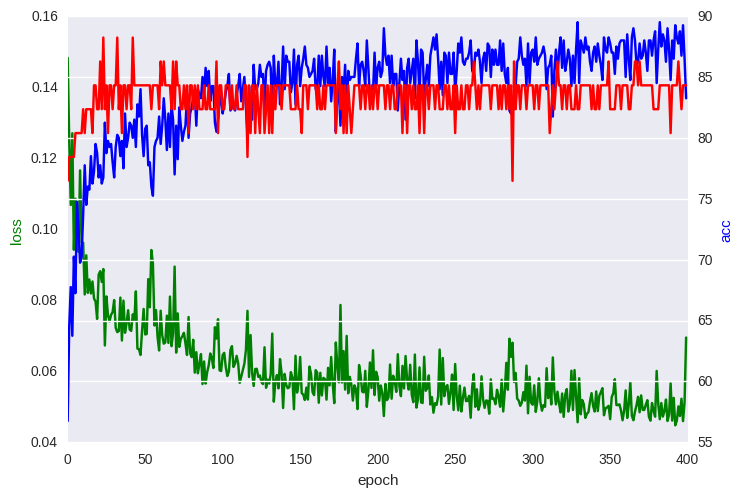

In [84]:
# Plot Acc and Loss
print(np.mean(np.array(test_acc)))
print(test_acc)
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(train_loss, 'g-')
ax2.plot(train_acc, 'b-')
ax2.plot(valid_acc, 'r-')

ax1.set_xlabel('epoch')
ax1.set_ylabel('loss', color='g')
ax2.set_ylabel('acc', color='b')
ax1.grid()


In [85]:
#TSNE
from sklearn.manifold import TSNE
tsne_df = pd.DataFrame()

tsne_df_train = pd.DataFrame()
tsne_df_train['PTID'] = Sub_train_kf[fid][:tr_split]    
tsne_df_train['subset'] = np.tile('train',len(tr_y))
tsne_df_train['KF'] = np.tile(fid,len(tr_y))

tsne_df_test = pd.DataFrame()
tsne_df_test['PTID'] = Sub_test_kf[fid]

tsne_df_test['subset'] = np.tile('test',len(te_y))
tsne_df_test['KF'] = np.tile(fid,len(te_y))

if use_aux_net:
    tsne_df_train['labels'] = np.argmax(tr_y,1)
    tsne_df_test['labels'] = np.argmax(te_y,1)
else:
    tsne_df_train['labels'] = tr_y
    tsne_df_test['labels'] = te_y

tsne_train_layers = {'l1':train_feature_1,'l2':train_feature_2}
tsne_test_layers = {'l1':test_feature_1,'l2':test_feature_2}

for l in tsne_train_layers:
    tsne = TSNE(n_components=2, random_state=0,init='pca')
    tsne_embed = tsne.fit_transform(tsne_train_layers[l])
    tsne_df_train['TSNE_{}_x'.format(l)] = tsne_embed[:,0]
    tsne_df_train['TSNE_{}_y'.format(l)] = tsne_embed[:,1]

for l in tsne_test_layers:
    tsne = TSNE(n_components=2, random_state=0,init='pca')
    tsne_embed = tsne.fit_transform(tsne_test_layers[l])
    tsne_df_test['TSNE_{}_x'.format(l)] = tsne_embed[:,0]
    tsne_df_test['TSNE_{}_y'.format(l)] = tsne_embed[:,1]

tsne_df = tsne_df_train.append(tsne_df_test)

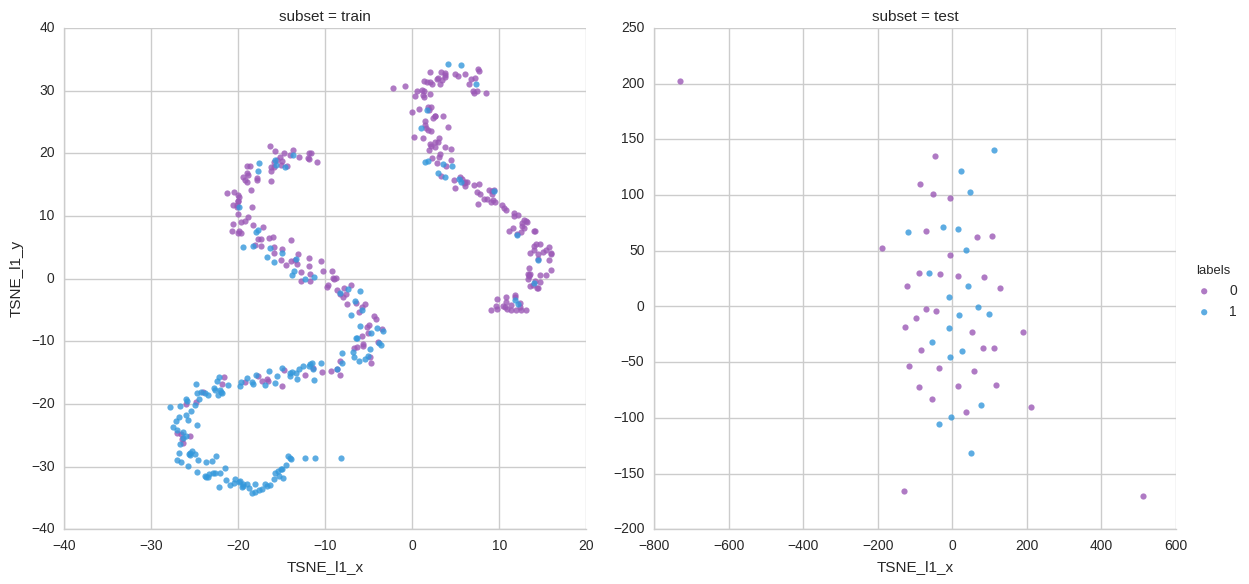

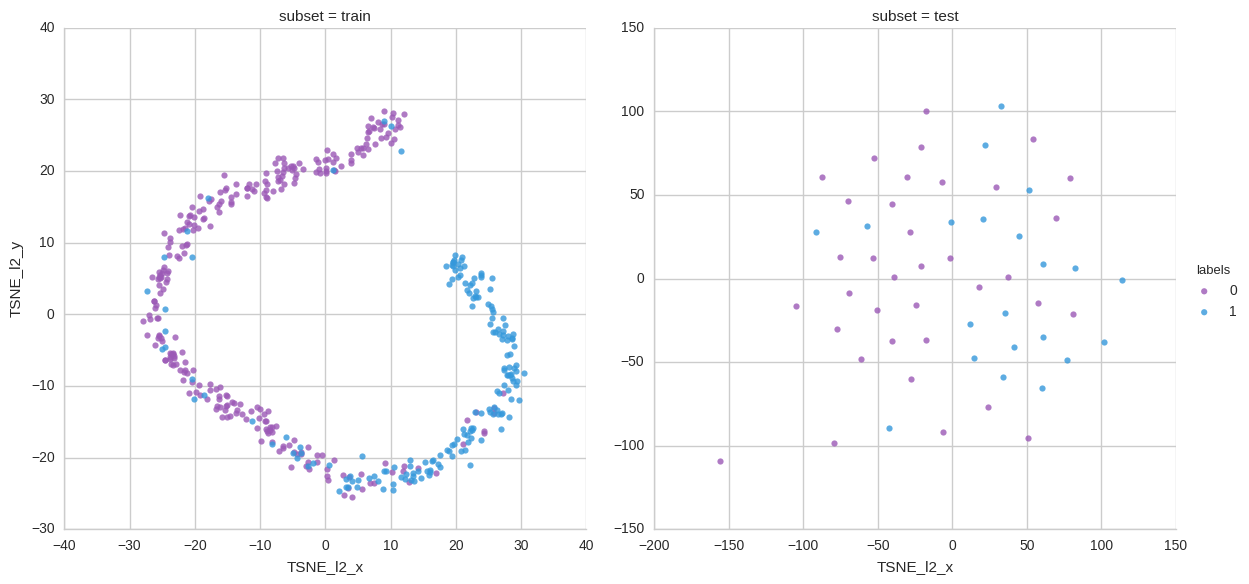

In [86]:
flatui = ["#9b59b6", "#3498db", "#e74c3c", "#34495e", "#2ecc71", "#95a5a6"]

with sns.axes_style("whitegrid"):
    g1 = sns.lmplot('TSNE_l1_x','TSNE_l1_y',fit_reg=False,hue='labels',col='subset',data=tsne_df,
                    markers='o',size=6,sharey=False,sharex=False,palette=flatui)
    g1 = sns.lmplot('TSNE_l2_x','TSNE_l2_y',fit_reg=False,hue='labels',col='subset',data=tsne_df,
                    markers='o',size=6,sharey=False,sharex=False,palette=flatui) 

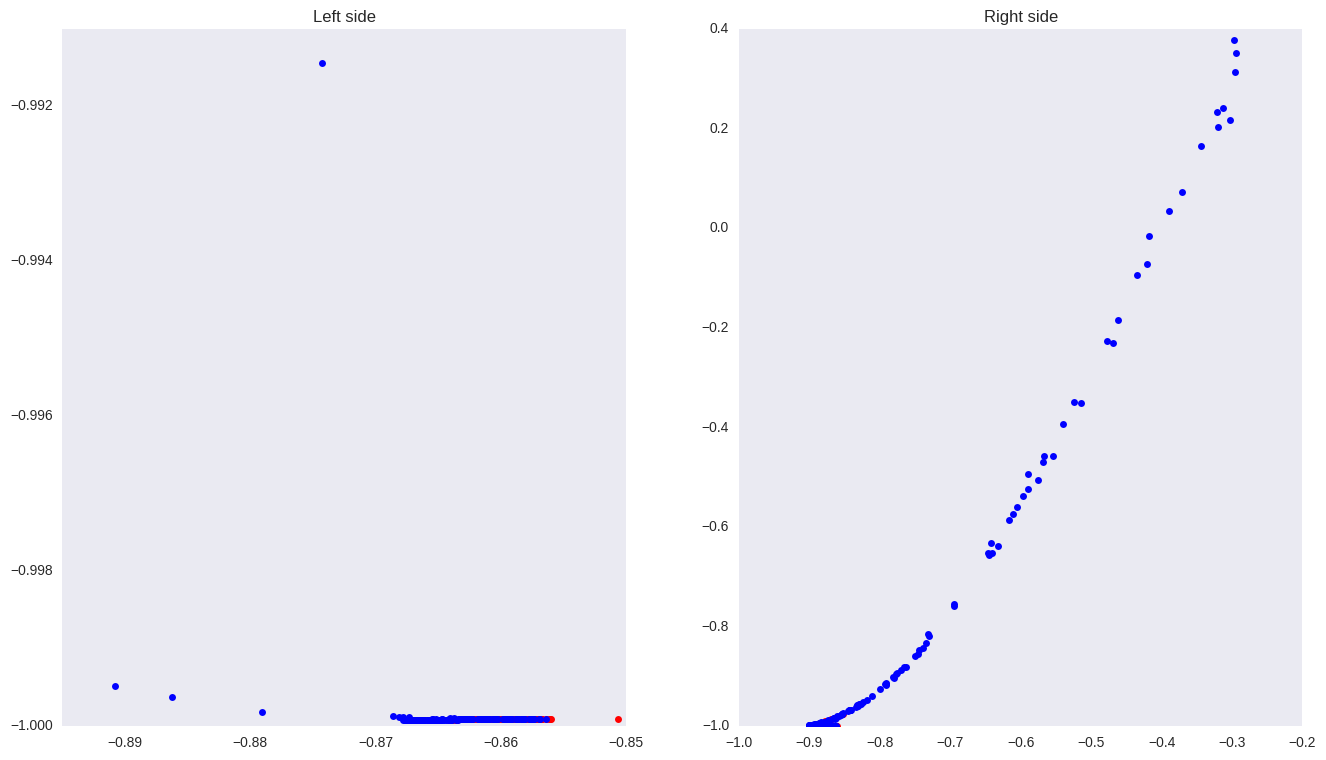

In [87]:
#Plot embeddings
f = plt.figure(figsize=(16,9))
c = ['#ff0000', '#0000ff', '#ffff00', '#00ff00', '#009999',
     '#ff00ff', '#00ffff', '#990000', '#999900', '#009900' ]
mark_size= 10

plt.subplot(1,2,1)
x = train_feature_1[:,0] 
y = train_feature_1[:,1] 
labels = tr_y #left_digits
for i in range(2):
    plt.plot(x[labels==i],y[labels==i],'.', c=c[i], markersize=mark_size)
    
# x = test_feature_1[:,0] 
# y = test_feature_1[:,1] 
# labels = te_y #left_digits
# for i in range(2):
#     plt.plot(x[labels==i],y[labels==i],'d', c=c[i+5], markersize=mark_size)

    
#plt.legend(['train_class_1', 'train_class_2', 'test_class_1', 'test_class_2'],loc=1)
plt.grid()
plt.title('Left side')

plt.subplot(1,2,2)
x = train_feature_2[:,0] 
y = train_feature_2[:,1] 
labels = tr_y #right_digits
for i in range(2):
    plt.plot(x[labels==i],y[labels==i],'.', c=c[i], markersize=mark_size)

# x = test_feature_2[:,0] 
# y = test_feature_2[:,1] 
# labels = te_y #right_digits
# for i in range(2):
#     plt.plot(x[labels==i],y[labels==i],'d', c=c[i+5], markersize=mark_size)

# #plt.legend(['train_class_1', 'train_class_2', 'test_class_1', 'test_class_2'], loc=1)
plt.grid()
plt.title('Right side')

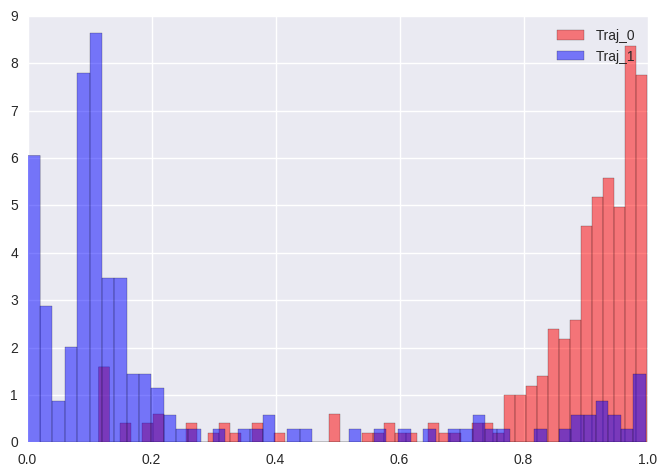

In [88]:
#print(np.max(tr_dist_df['distance'].values))
#sns.factorplot(y='distance',x='label',data=tr_dist_df,kind='box')
a = tr_dist_df[tr_dist_df['label']==0]['distance'].values
b = tr_dist_df[tr_dist_df['label']==1]['distance'].values
plt.hist(a,bins=50,normed=1,facecolor='red',alpha=0.5,label='Traj_0')
plt.hist(b,bins=50,normed=1,facecolor='blue',alpha=0.5,label='Traj_1')
plt.legend()